In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import time
from operator import itemgetter
import random
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# File reading

stations_file = '/content/drive/MyDrive/keys_df.csv'
stations_df = pd.read_csv(stations_file)
stations_list = stations_df['0'].values.tolist()

data_dict = {}
base_path = '/content/drive/MyDrive/dataset'
dataset = pd.DataFrame()
for item in stations_list:
  filename = '/dataset_' + str(item) + '.csv'
  filepath = base_path + filename
  df = pd.read_csv(filepath)
  data_dict[item] = df

In [4]:
# First dataset - all variables excluding nearby stations' data

X_1 = pd.DataFrame()
y_1 = pd.DataFrame()
for key, df in data_dict.items():
    df_ = df.iloc[:, 1:54]
    y = df_['intensidad']
    X = df_.drop(['intensidad'], axis=1)
    X_1 = pd.concat([X_1, X])
    y_1 = pd.concat([y_1, y])
X_1 = X_1.reset_index(drop=True)
y_1 = y_1.reset_index(drop=True)

In [5]:
# Second dataset - most significative vars from first dataset

X_2 = X_1[['ocupacion', 'tp', 'ssr', 'u10', 'v10', 't2m', '7', '8', '12', \
           'holiday', 'residential_a_25', 'parks_a_500', 'roads_1_a_25', \
           'parks_a_1000', 'residential_a_50', 'roads_3_a_100', 'roads_3_a_25', \
           'roads_1_a_500', 'roads_2_a_200']]     

y_2 = y_1  

In [6]:
# Third dataset - traffic & occupancy mem, meteorology and air quality

X_3 = pd.DataFrame()
y_3 = pd.DataFrame()
for key, df in data_dict.items():
    df_ = df[['intensidad', 'ocupacion', 'tp', 'ssr', 'u10', 'v10', 't2m', '7', \
              '8', '12', 'holiday']]
    df_int = df_['intensidad'].values.tolist()
    int_mem = df_['intensidad'].values.tolist()
    df_oc = df_['ocupacion'].values.tolist()
    oc_mem = df_['ocupacion'].values.tolist()
    del df_int[:96]
    del int_mem[-96:]
    del df_oc[:96]
    del oc_mem[-96:]
    df_ = df_.iloc[96:]
    df_ = df_.drop(columns=['intensidad', 'ocupacion'])
    df_['int_mem'] = int_mem
    df_['oc_mem'] = oc_mem
    y = pd.Series(df_int)
    X_3 = pd.concat([X_3, df_])
    y_3 = pd.concat([y_3, y])
X_3 = X_3.reset_index(drop=True)
y_3 = y_3.reset_index(drop=True)

In [7]:
# Fourth dataset - traffic mem, and meteorology

X_4 = X_3[['int_mem', 'tp', 'ssr', 'u10', 'v10', 't2m']]
y_4 = y_3  

In [8]:
# Fifth dataset - meteorology and land use

#X_1_cols = X_1.columns.values.tolist()
#X_1_cols = X_1_cols[4:46]
cols_ = ['residential_a_25', 'parks_a_500', 'roads_1_a_25', 'parks_a_1000', \
         'residential_a_50', 'roads_3_a_100', 'roads_3_a_25', 'roads_1_a_500', \
         'roads_2_a_200', 'tp', 'ssr', 'u10', 'v10', 't2m']
X_5 = X_1[cols_]
y_5 = y_1


In [9]:
# Sixth dataset - only traffic and occupancy mem

X_6 = X_3[['int_mem', 'oc_mem']]
y_6 = y_3

In [10]:
# Seventh dataset - historical buffer traffic with best predictors (random station)

keys_ = list(data_dict.keys()) 
key = random.choice(keys_)
keys_.remove(key)
df_t = data_dict[key]
int_ = df_t['intensidad'].values.tolist()
del int_[-96:]
col_len = len(df_t.columns)
df_t = df_t.iloc[:, 55:col_len]
df_t = df_t.iloc[96: , :]
X_7 = df_t
y_7 = pd.Series(int_)


In [11]:
# Eigth dataset - validation of seventh dataset with another random station

key = random.choice(keys_)
keys_.remove(key)
df_t = data_dict[key]
int_ = df_t['intensidad'].values.tolist()
del int_[-96:]
col_len = len(df_t.columns)
df_t = df_t.iloc[:, 55:col_len]
df_t = df_t.iloc[96: , :]
X_8 = df_t
y_8 = pd.Series(int_)

In [12]:
# Ninth and tenth datasets - Bordeaux transfer learning

ds_bordeaux = pd.read_csv('/content/drive/MyDrive/df_bordeaux.csv')

X_9 = ds_bordeaux[['ssr', 'u10', 'v10', 't2m', 'tp', 'int_mem']]
y_9 = ds_bordeaux['int']
X_10 = ds_bordeaux[['ssr', 'u10', 'v10', 't2m', 'tp', 'roads_1_25', \
                   'parks_a_500', 'residential_a_25', 'parks_a_1000', \
                   'residential_a_50', 'roads_2_200', 'roads_3_100', \
                   'roads_1_500', 'roads_3_25']]
y_10 = ds_bordeaux['int']

In [13]:
# Eleventh and twelfth datasets - Constance transfer learning

ds_constance = pd.read_csv('/content/drive/MyDrive/df_constance.csv')

X_11 = ds_constance[['ssr', 'u10', 'v10', 't2m', 'tp', 'int_mem']]
y_11 = ds_constance['int']
X_12 = ds_constance[['ssr', 'u10', 'v10', 't2m', 'tp', 'roads_1_25', \
                   'parks_a_500', 'residential_a_25', 'parks_a_1000', \
                   'residential_a_50', 'roads_2_200', 'roads_3_100', \
                   'roads_1_500', 'roads_3_25']]
y_12 = ds_constance['int']

In [14]:
# Train/test split(function)

dataset_dict = {'ds_1' : (X_1, y_1), 'ds_2' : (X_2, y_2), 'ds_3' : (X_3, y_3), \
                'ds_4' : (X_4, y_4), 'ds_5' : (X_5, y_5), 'ds_6' : (X_6, y_6), \
                'ds_7' : (X_7, y_7), 'ds_8' : (X_8, y_8), 'ds_9' : (X_9, y_9), \
                'ds_10' : (X_10, y_10), 'ds_11' : (X_11, y_11), \
                'ds_12' : (X_12, y_12)}

def train_test(dataset_dict__):
    '''Separates into train/test/validation splits from a given recopilation of datasets'''
    train_test_dict = {}
    for key, tr_ts in dataset_dict__.items():
        X = tr_ts[0]
        y = tr_ts[1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
        train_test_dict[key] = (X_train, y_train, X_test, y_test, X_val, y_val)
    return train_test_dict

In [15]:
train_test_val = train_test(dataset_dict)

In [16]:
# Fine tuner (function)

def fine_tuner(train_test_val_dict):
    '''Finds the bast parameters for the model'''
    param_dict = {}
    gridParams = {
        'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9],
        'lambda_l1' : [1, 100, 1000, 10000],
        'num_leaves': [16, 32, 64, 100, 200, 1000, 10000],
        'boosting_type' : ['gbdt'],
        'objective' : ['regression'],
        'max_depth' : [5, 10, 15, 20, 50, 75, 100, 125, 150, 200],
        'random_state' : [33], 
        'min_split_gain' : [0.01, 0.1, 1, 10, 100, 1000],
        'min_data_in_leaf':[1, 10, 100, 1000, 10000],
        'metric':['rmse']
        }
    for key, set_ in train_test_val_dict.items():
        X_val =  set_[4]
        y_val = set_[5]
        clf = lgb.LGBMRegressor()
        grid = RandomizedSearchCV(clf, gridParams, verbose=1, cv=10, n_jobs = -1, n_iter=5)
        grid.fit(X_val,y_val)
        print('Model with ' + key + ' fitted. Searching best params.')
        param_dict[key] = grid.best_params_
        print('Model with ' + key + ' tuned.')
    return param_dict

In [17]:
par_dict = fine_tuner(train_test_val)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model with ds_1 fitted. Searching best params.
Model with ds_1 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_2 fitted. Searching best params.
Model with ds_2 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_3 fitted. Searching best params.
Model with ds_3 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_4 fitted. Searching best params.
Model with ds_4 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_5 fitted. Searching best params.
Model with ds_5 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_6 fitted. Searching best params.
Model with ds_6 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_7 fitted. Searching best params.
Model with ds_7 tuned.
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Model with ds_8 fitted. Searching best params.
Model with ds_8 tuned.
Fitting 10 fo

In [18]:
with open('/content/drive/MyDrive/par_dict.pkl', 'wb') as handle:
    pickle.dump(par_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('/content/drive/MyDrive/par_dict.pkl', 'rb') as handle:
    par_dict = pickle.load(handle)

In [20]:
# Eval & model app

def model_app(train_test_val_dict, params_dict):
  metrics_dict = {}
  feats_imp_dict = {}
  models_dict = {}
  errs_dict = {}
  i = 1
  for key, set_ in train_test_val_dict.items():
    print('Model with ' + str(key) +'.')
    modelfile = 'model_' + str(i) + '.txt'
    X_train = set_[0]
    y_train = set_[1]
    X_test = set_[2]
    y_test = set_[3]
    params = par_dict[key]
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X_train, y_train, verbose=-1, eval_metric='rmse')
    lgb_model.booster_.save_model(modelfile)
    predictions = lgb_model.predict(X_test)
    predictions_ = lgb_model.predict(X_train)
    pred = np.array(predictions)
    pred_ = np.array(predictions_)
    lab = np.array(y_test)
    lab_ = np.array(y_train)
    print('Predicted ' + key)
    r2 = r2_score(lab, pred)
    r2_ = r2_score(lab_, pred_)
    adj_r2 = 1-(1-r2)*(len(pred)-1)/(len(pred)-len(X_test.columns)-1)
    mae = mean_absolute_error(lab, pred)
    rmse = mean_squared_error(lab, pred, squared=False)
    r2 = '%.3f'%(r2)
    r2_ = '%.3f'%(r2_)
    adj_r2 = '%.3f'%(adj_r2)
    rmse = '%.3f'%(rmse)
    metrics_dict[key] = {'mae' : mae, 'rmse' : rmse, 'r2' : r2, 'adj_r2' : adj_r2}
    print('Computed metrics for ' + key)
    print('Results: ')
    features = X_train.columns.tolist()
    feat_importances = pd.Series(lgb_model.feature_importances_, index=features)
    feat_importances = feat_importances.sort_values(ascending=False)
    feats_imp_dict[key] = feat_importances
    print(feat_importances)
    print(metrics_dict[key])
    print('Overfitting monitoring: r2 test = ' + str(r2) + ' , r2 train = ' + \
          str(r2_))
    models_dict[i] = lgb_model
    errs_dict[key] = (lab, pred)
    i += 1
  return metrics_dict, feats_imp_dict, models_dict, errs_dict


In [21]:
metrics, feats_imp, models, errors = model_app(train_test_val, par_dict)

Model with ds_1.
Predicted ds_1
Computed metrics for ds_1
Results: 
ssr                   5407
t2m                   5146
ocupacion             3944
u10                   3934
v10                   3716
tp                    3145
8                     2365
7                     2274
12                    1796
residential_a_25      1194
holiday               1029
parks_a_500            872
roads_1_a_25           792
roads_3_a_1000         517
residential_a_50       515
roads_3_a_25           484
parks_a_1000           462
roads_1_a_500          425
roads_3_a_100          416
roads_2_a_500          404
roads_2_a_200          351
roads_3_a_50           349
roads_3_a_200          346
hospitals_a_1000       321
roads_2_a_1000         314
residential_a_200      285
schools_a_1000         280
parks_a_200            267
roads_1_a_200          265
roads_2_a_100          262
schools_a_500          255
residential_a_100      254
roads_3_a_500          252
residential_a_1000     251
roads_1_a_1000

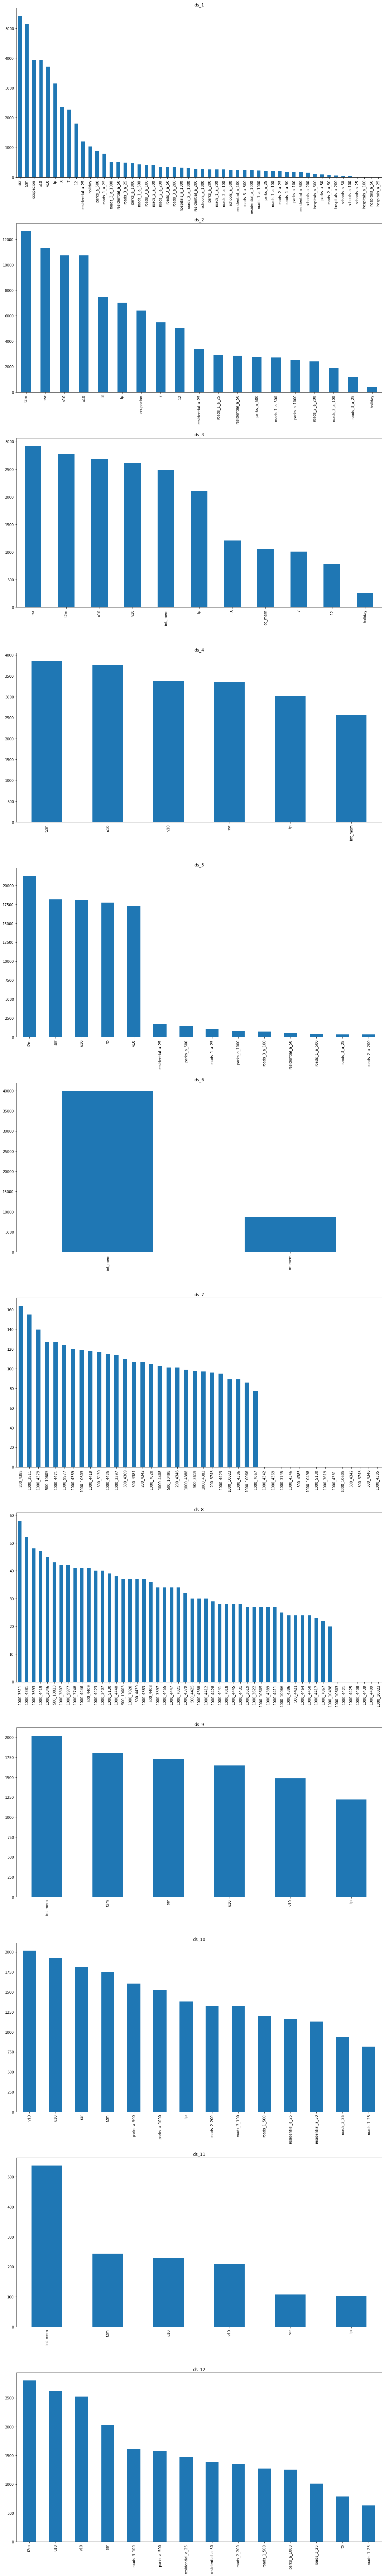

In [22]:
i = 0
j = 0


fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(15,100))
for key, imps in feats_imp.items():
    imps.plot.bar(ax=axes[i])
    title = key + ' feat importances'
    axes[i].title.set_text(key)
    if i != 12:
        i += 1
    elif i == 12:
        break

fig.tight_layout()
plt.show()

In [23]:
errors_calc = {}

for key, value in errors.items():
  lab = value[0]
  pred = value[1]
  lab = np.squeeze(lab)
  errs = lab-pred
  errors_calc[key] = errs

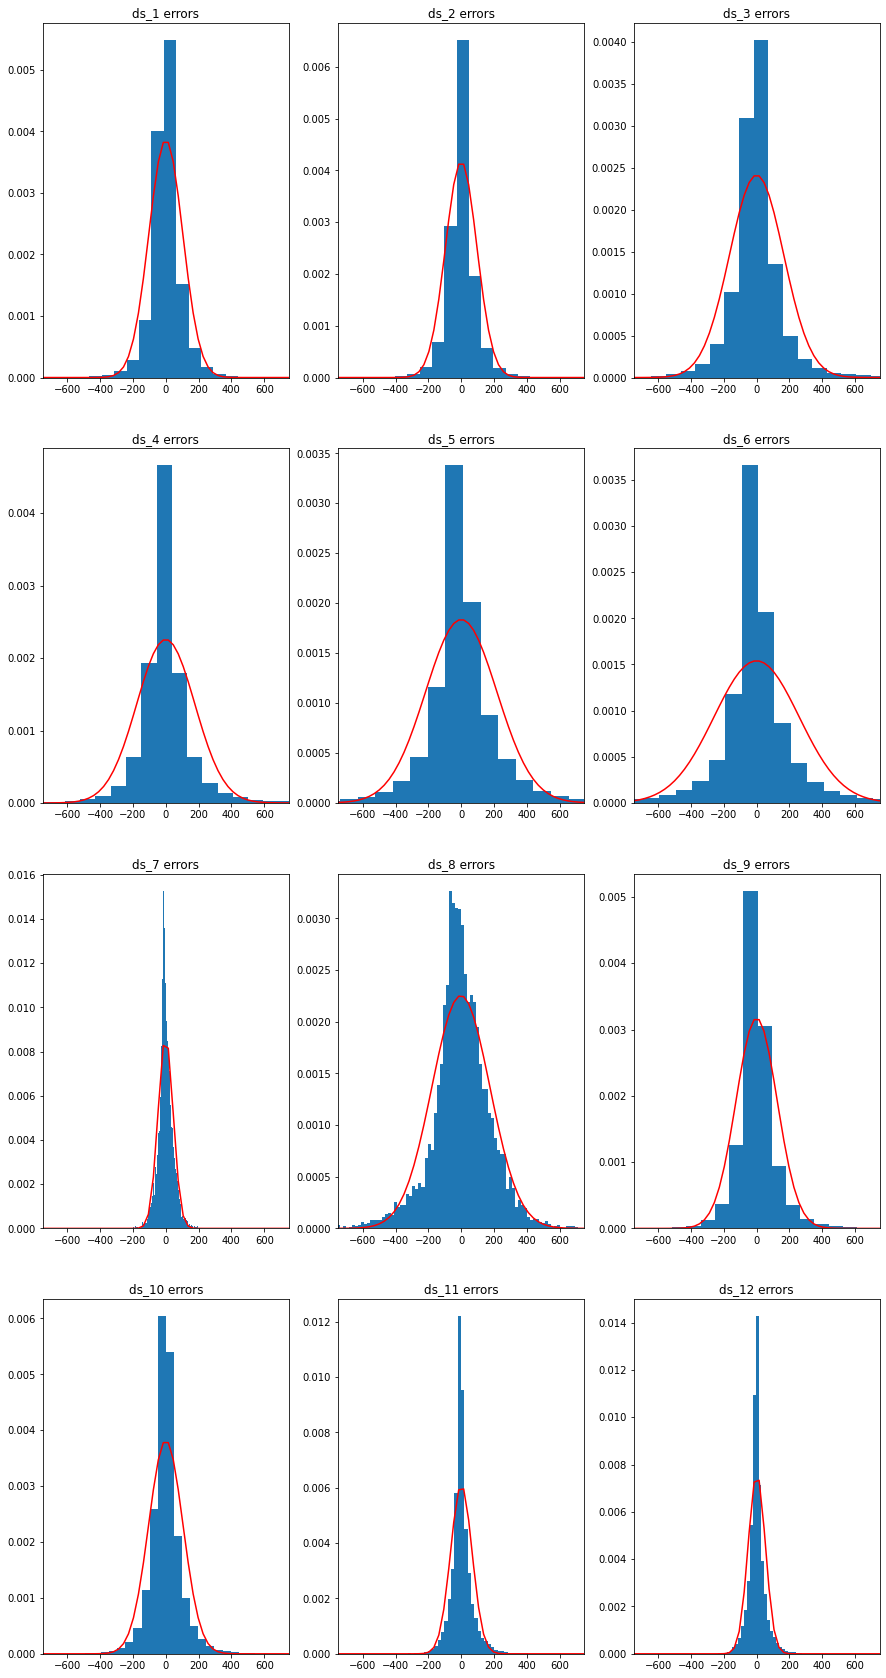

In [27]:
i = 1

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,30))
for key, errs in errors_calc.items():
    mu, sigma = stats.norm.fit(errs)
    points = np.linspace(-1500, 1500,100)
    pdf = stats.norm.pdf(points,loc=mu,scale=sigma)
    ax = plt.subplot(4, 3, i)
    ax.set_title(key + ' errors')
    ax.hist(errs, 90, density=True);
    ax.plot(points, pdf, color='r')
    ax.set(xlim=(-750, 750))
    ax.set(xlim=(-750, 750))
    if i == 12:
      break
    i += 1


plt.show()